## Аналитика для Яндекс.Афиша

Маркетинговому отделу аналитики Яндекс.Афиши нужно помочь маркетологам снизить расходы — отказаться от невыгодных источников трафика и перераспределить бюджет. Есть данные Яндекс.Афиши с июня 2017 по конец мая 2018 года: 
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.


###### Цель и задачи

Цель раборы - определить выгоные и невыгодные источники трафика. Для достижения цели поставлены следующие задачи:
1. Определить как клиенты пользуются сервисом,
2. Выяснить когда клиенты делают первые покупки,
3. Рассчитать сколько денег приносит компании каждый клиент,
4. Выяснить когда расходы на привлечение клиента окупаются

###### План работы

1. Общая информация
2. Предобработка
3. Рассчет метрик:
 - продуктовые метрики
 - метрики электронной коммерции
 - маркетинговые метрики
4. Выводы и реккомендации 

### Общая информация

In [1]:
#импортируем все необходимые библиотеки 
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt 
import seaborn as sns
import matplotlib.colors
import numpy as np


In [2]:
#выведем первые строки датасетов и информацию о таблицах
visits = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/visits_log.csv')
orders = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/orders_log.csv')
costs = pd.read_csv('C:/Users/alfro/Documents/Daria_Jupyter/Datasets/costs.csv')

display(visits.head())
display(visits.info())
display(orders.head())
display(orders.info())
display(costs.head())
costs.info()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Сохраним в переменной visits лог сервера с данными о посещениях сайта Яндекс.Афиши. В этой таблице следующие колонки:
- Device - устройство с которого заходили на Афишу
- End Ts - время окончания сессии 
- Source Id - закодированный источник с которого перешел пользователь 
- Start Ts - время начала сессии 
- Uid - уникальный id пользователя 

Каждая строка представляет собой данные об одной интернет-сессии. Всего таких строк 359400. Пропусков нет, однако даты закодированы типом Object, что для выполнения нашей работы требует корректировки. Также стоит заметить, что id пользователей представлены типом unit64 - что не очень логично с точки зрения того, что это не число, однако взможно такой тип данных нужен для того, чтобы переменная должна имела точный размер при портировании на другую систему, например. Тип источника также int64

В переменной order сохраним данные о заказах. В таблице 4 столбца:
- Buy Ts - время покупки 
- Revenue - соимость, измеряемая в у.е. 
- Uid - уникальный id пользователя

Каждая строка - это одна покупка сделенная в период с июня 2017 по конец мая 2018 года. Всего 50415 строк без пропусков. Время покупки закодировано типом object.


В переменной costs сохраним статистику рекланых расходов. В таблице 3 столбца:
- source_id	- источник, с котрого перешел пользователь
- dt - дата, когда пришел пользователь (год, месяц, день)	
- costs - затраты 

В таблице 2542 строки без пропусков. Дата закодирована типом object, источник - типом int64, что возможно не очень корректно, но подойдет для наших целей

###### Вывод

В данных нет пропусков, однако тип данных не всегда соотвествует сохраненным в них значениям. Для анализа нам в первую очередь потребуются даты, поэтому изменим их тип данных во всех трех таблицах, приведем к единому стилю все названия, а также выполним проверку на дубликаты 

### Предобработка

In [3]:
#изменим тип данных у всех дат
visits['End Ts'] = pd.to_datetime(visits['End Ts'], format='%Y-%m-%d %H:%M:%S')
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'], format='%Y-%m-%d %H:%M:%S')

orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'], format='%Y-%m-%d %H:%M:%S')

costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')

Изменим названия столбцов, убрав большую букву и замнив пробел на нижнее подчеркивание

In [4]:
display(visits.columns) 
orders.columns

Index(['Device', 'End Ts', 'Source Id', 'Start Ts', 'Uid'], dtype='object')

Index(['Buy Ts', 'Revenue', 'Uid'], dtype='object')

In [5]:
new_cols1 = [name.lower().replace(' ', '_') for name in visits.columns] 
visits.columns = new_cols1

new_cols2 = [name.lower().replace(' ', '_') for name in orders.columns]
orders.columns = new_cols2

In [6]:
display(orders.info())
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy_ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end_ts     359400 non-null  datetime64[ns]
 2   source_id  359400 non-null  int64         
 3   start_ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [7]:
#проверка на дубликаты 
print("Колличество дубликатов в таблице costs:", costs.duplicated().sum())
print("Колличество дубликатов в таблице orders:", orders.duplicated().sum())
print("Колличество дубликатов в таблице visits:", visits.duplicated().sum())

Колличество дубликатов в таблице costs: 0
Колличество дубликатов в таблице orders: 0
Колличество дубликатов в таблице visits: 0


###### Вывод

Названия всех столбцов выглядят одинаково и данные, котрые нам нужны для работы, приведены к корректным типам - можно приступать к анализу 

### Расчет метрик 

#### Продуктовые метрики

#####  Рассчет DAU, WAU и MAU

In [8]:
#выделим в отдельные столбцы год, месяц и неделю, а также полную дату 
visits['session_year'] = visits['start_ts'].dt.year

#visits['session_month'] = visits['start_ts'].dt.month
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')

#visits['session_week'] = visits['start_ts'].dt.week
visits['session_week'] = visits['start_ts']. astype('datetime64[W]')

visits['session_date'] = visits['start_ts'].dt.date

visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,2017-12-14,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,2018-02-15,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,2017-06-29,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,2018-05-17,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,2017-12-21,2017-12-27


In [9]:
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'})
wau_total = visits.groupby('session_week').agg({'uid': 'nunique'})
mau_total = visits.groupby('session_month').agg({'uid': 'nunique'})

Отразим расчитанные показатели на графиках 

Среднее DAU за весь период: 907


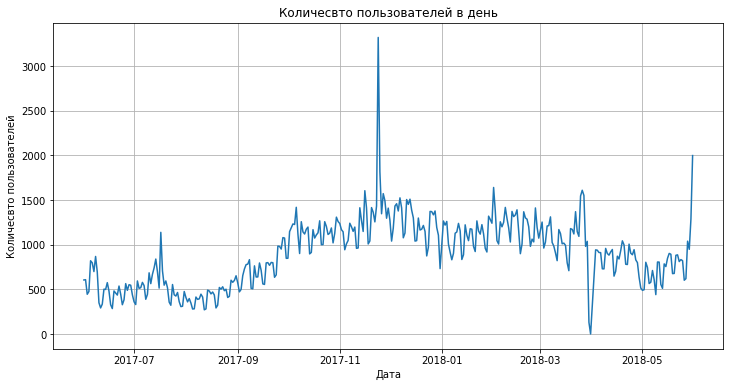

In [10]:
dau_total.plot(
    figsize=(12,6),
    grid = True,
    legend= False)
plt.title('Количесвто пользователей в день')
plt.xlabel("Дата")
plt.ylabel("Количесвто пользователей")


print('Среднее DAU за весь период:', int(dau_total.mean()))



Среднее количество посетителей в день составляет 907 визитов. По графику видно что был один пик с большим колличесвом посетителей перед декабрем - возможно в продажу поступили билеты сразу на несколько мероприятий на новый год (например, новогодние ёлки). Также видно, что в конце марта был резкий спад - возможно, были технические неполадки в тот день 

Среднее WAU за весь период: 5724


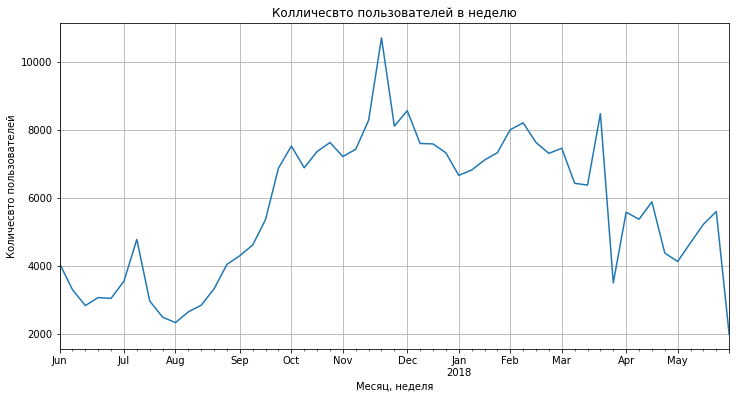

In [11]:
wau_total.plot(
    figsize=(12,6),
    grid = True,
    legend= False)
plt.title('Колличесвто пользователей в неделю')
plt.xlabel("Месяц, неделя")
plt.ylabel("Количесвто пользователей")

print('Среднее WAU за весь период:', int(wau_total.mean()))


Среднее количество посетителей в неделю - более 5700 визитов. Основной пик визитов приходится на середину ноября - можно предпроложить, что люди покупают билеты детям на новогодние мероприя или покупают что-то в подарок

Среднее MAU за весь период: 23228


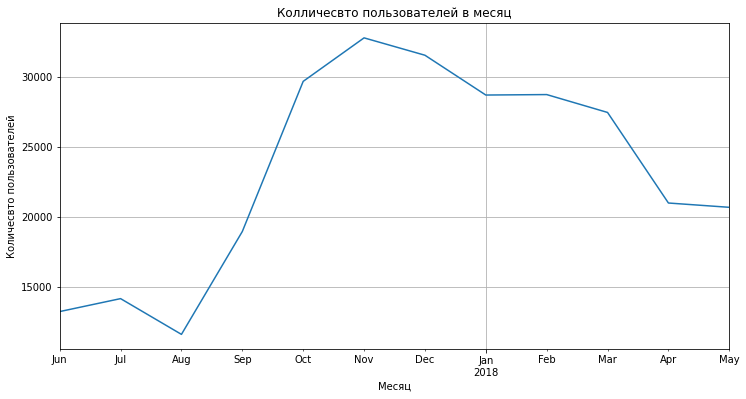

In [12]:
mau_total.plot(
    figsize=(12,6),
    grid = True,
    legend= False)
plt.title('Колличесвто пользователей в месяц')
plt.xlabel("Месяц")
plt.ylabel("Количесвто пользователей")

print('Среднее MAU за весь период:', int(mau_total.mean()))

Среднее количество посетителей в месяц более 23000. Летом 2017 года пользователей было значительно меньше - возможно, в 2017 году сервис был не так популярен и о нем знало меньше людей, одноко начиная с августа количество посетителей стремительно растет (возможно больше людей узнало о сервисе + окончание летних каникул). В марте пользователей становится меньше, возможно эта кривая будет идти на спад вплоть до начала нового учебного года. 

##### Сколько раз за день пользователи заходят на сайт

In [13]:
#Определим, сколько раз за день пользователи в среднем заходят на сайт
sessions_per_day = visits.groupby(['session_date', 'uid']).agg({'uid': 'count'})
sessions_per_day.describe()

,uid
count,330509.000000
mean,1.087414
std,0.371823
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,10.000000


Большинство пользователей в среднем заходят на сайт 1 раз в день, при этом только менее четверти заходят чаще. Посмотрим сколько времени люди обычно проводят на сайте. 

In [14]:
#чтобы отразить этот показатель в динамике, произведем некоторые преобразования 
sessions_per_day.columns = ['n_sessions']
sessions_per_day = sessions_per_day.reset_index()
sessions_per_day['session_date'] = pd.to_datetime(sessions_per_day['session_date'], format='%Y-%m-%d')

#сгруппируем данные по дате и посчитаем сколько в среденем сессий на 1 человека приходилось в этот день 
sessions_per_day_round = sessions_per_day.groupby('session_date').agg({'n_sessions' : 'mean'})

Text(0, 0.5, 'Количесвто сессий')

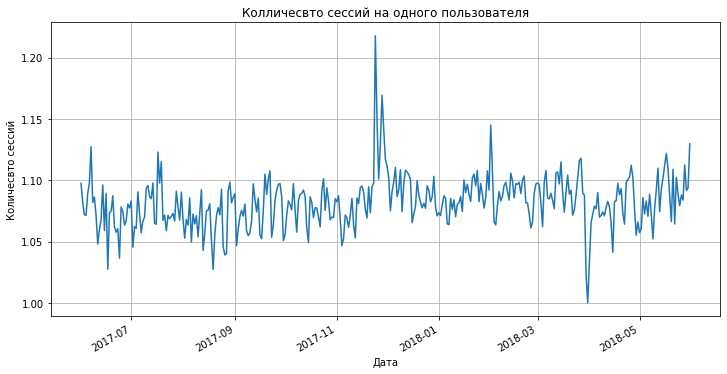

In [15]:
sessions_per_day_round.plot(
    figsize=(12,6),
    grid = True,
    legend= False)
plt.title('Колличесвто сессий на одного пользователя')
plt.xlabel("Дата")
plt.ylabel("Количесвто сессий")


На графике видно, что в среднем на человека приходится чуть более одной сессии и даже пиковые значения не сильно экстемальные. Однако даже эти пики календарно совпадают с данными по дневной активности пользователей - перед декабрем тот же пик, что и на графике про DAU. 

##### Сколько времени пользователи проводят на сайте

Добавим в таблицу visits еще один столбец с разностью начала и конца сессии. Также построим график распределения по секундам

Text(0, 0.5, 'Количесвто сессий')

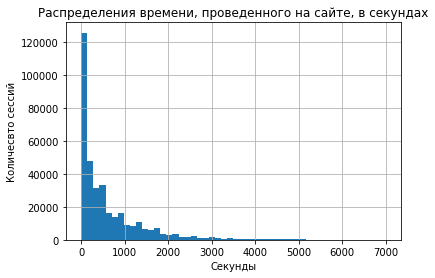

In [16]:
visits['visits_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

visits['visits_duration_sec'].hist(bins=50, range=(0, 7000))
plt.title('Распределения времени, проведенного на сайте, в секундах')
plt.xlabel("Секунды")
plt.ylabel("Количесвто сессий")



In [17]:
print('Колличесвто сессий длинной 0 секунд:', len(visits.query('visits_duration_sec == 0')))

Колличесвто сессий длинной 0 секунд: 35794


Виден явный пик около 0 (а так же, довольно много сессий длительностью 0 секунд, что довольно странно, возможно стоит внимательнее их рассмотреть на предмет технических неполадок со стороный сайта). Данные в целом распределены неранномерно, а значит среднее и медиана не подходят для характеристики средней продолжительности сессии. Воспользуемся модой. 

In [18]:
print("Продолжительность типичной пользовательской сессии в секундах:", 
      int(visits.query('visits_duration_sec != 0')['visits_duration_sec'].mode()))

Продолжительность типичной пользовательской сессии в секундах: 60


В среденем пользователи проводят на сайте 1 минуту. Если за это время они успевают сделать заказ, то этого времени достаточно. Зная что пользователи в среднем заходят 1 раз в день, можно предположить, что они заходят на Яндекс.Афиша только, чтобы оформить покупку, а информацию о мероприятиях получают из других источников (с кторых, возможно и переходят на Афишу)

##### Retention Rate

Коэффкциент удержания пользователей показывает сколько из тех, кто однажды уже совершал покупку вернуться снова. Для расчета retention rate будем использовать таблицу с заказами, так как именно в ней отражены те пользователи, которые совершали покупки, и когорты юудем формировать по месяцам, так как у нас достаточно для этого данных и в целом месячный период оптимально отражет работу такого сервиса как Яндекс.Афиша

In [19]:
#вытащим дату из указания времнени покупки
orders['buy_date'] = orders['buy_ts'].dt.date
orders['buy_date'] = pd.to_datetime(orders['buy_date'], format='%Y-%m-%d')

In [20]:
#orders.info()

In [21]:
#соберем отдельно даты для первых покупок
#и добавим этот столбец к таблице заказов
first_buy_date = orders.groupby(['uid'])['buy_date'].min()
first_buy_date.name = 'first_buy_date'
orders = orders.join(first_buy_date,on='uid') 
orders.head()

,buy_ts,revenue,uid,buy_date,first_buy_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [22]:
#добавляем столбцы, где вытаскиваем месяц из даты заказа и даты певого заказа
#cтолбец с месяцем первого заказа и есть когорта
orders['first_order_month'] = orders['first_buy_date'].astype('datetime64[M]')
orders['order_month'] = orders['buy_date'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,buy_date,first_buy_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01


In [23]:
#сгруппируем данные по когорте и месяцу совершения заказа 
#также в этом пункте посчитаем сумму заказа - в этой задаче, это не нужно, но пригодится потом
orders_grouped_by_cohorts = orders.groupby(['first_order_month','order_month']).agg({'uid':'nunique', 'revenue':'sum'})
orders_grouped_by_cohorts

uid   revenue
first_order_month order_month                
2017-06-01        2017-06-01   2023   9557.49
                  2017-07-01     61    981.82
                  2017-08-01     50    885.34
                  2017-09-01     54   1931.30
                  2017-10-01     88   2068.58
...                             ...       ...
2018-03-01        2018-05-01     58   1114.87
2018-04-01        2018-04-01   2276  10600.69
                  2018-05-01     69   1209.92
2018-05-01        2018-05-01   2988  13925.76
2018-06-01        2018-06-01      1      3.42

[79 rows x 2 columns]

In [24]:
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()

#Найдём lifetime когорты. Из месяца совершения заказа вычтем месяц когорты 
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'].head() 

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: cohort_lifetime, dtype: timedelta64[ns]

In [25]:
#преобразуем lifetime в число месяцев, прошедших между датами
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')

#так как константа, это средняя длина месяца, даты нужно округлить и превратить в целые числа
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
orders_grouped_by_cohorts['cohort_lifetime'].head()

0    0
1    1
2    2
3    3
4    4
Name: cohort_lifetime, dtype: int32

In [26]:
#Получили целое число месяцев, обозначающее порядковый месяц совершения покупки относительно месяца первой покупки.
orders_grouped_by_cohorts.head()

,first_order_month,order_month,uid,revenue,cohort_lifetime
0,2017-06-01,2017-06-01,2023,9557.49,0
1,2017-06-01,2017-07-01,61,981.82,1
2,2017-06-01,2017-08-01,50,885.34,2
3,2017-06-01,2017-09-01,54,1931.30,3
4,2017-06-01,2017-10-01,88,2068.58,4


In [27]:
#Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц
initial_users_count = orders_grouped_by_cohorts[orders_grouped_by_cohorts['cohort_lifetime'] == 0][['first_order_month','uid']]
initial_users_count

,first_order_month,uid
0,2017-06-01,2023
12,2017-07-01,1923
23,2017-08-01,1370
33,2017-09-01,2581
42,2017-10-01,4340
50,2017-11-01,4081
57,2017-12-01,4383
63,2018-01-01,3373
68,2018-02-01,3651
72,2018-03-01,3533


In [28]:
#Переименуем столбец для удобства
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 

In [29]:
#Объединим данные по когортам с исходным количеством пользователей в когорте
orders_grouped_by_cohorts = orders_grouped_by_cohorts.merge(initial_users_count,on='first_order_month')
orders_grouped_by_cohorts.head()

,first_order_month,order_month,uid,revenue,cohort_lifetime,cohort_users
0,2017-06-01,2017-06-01,2023,9557.49,0,2023
1,2017-06-01,2017-07-01,61,981.82,1,2023
2,2017-06-01,2017-08-01,50,885.34,2,2023
3,2017-06-01,2017-09-01,54,1931.30,3,2023
4,2017-06-01,2017-10-01,88,2068.58,4,2023


In [30]:
#рассчитаем Retention Rate
orders_grouped_by_cohorts['retention'] = orders_grouped_by_cohorts['uid'] / orders_grouped_by_cohorts['cohort_users'] 

In [31]:
#Оставим в данных о месяце первого заказа только год и месяц
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m') 

In [32]:
retention_pivot = orders_grouped_by_cohorts.pivot_table(
    index='first_order_month',
    columns='cohort_lifetime',
    values='retention',
    aggfunc='sum') 

retention_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06,1.0,0.030153,0.024716,0.026693,0.043500,0.033119,0.030648,0.023233,0.028670,0.022244,0.022244,0.026199
2017-07,1.0,0.027041,0.029641,0.033281,0.025481,0.019761,0.018721,0.020281,0.021841,0.011440,0.013521,NaN
2017-08,1.0,0.042336,0.038686,0.032117,0.029197,0.023358,0.021898,0.032117,0.013869,0.022628,NaN,NaN
2017-09,1.0,0.050368,0.038745,0.028671,0.020147,0.024797,0.025571,0.014336,0.016660,NaN,NaN,NaN
2017-10,1.0,0.047465,0.028341,0.021198,0.021429,0.016590,0.012903,0.015438,NaN,NaN,NaN,NaN
2017-11,1.0,0.054398,0.029405,0.025974,0.019848,0.011762,0.015192,NaN,NaN,NaN,NaN,NaN
2017-12,1.0,0.033311,0.023500,0.022131,0.011408,0.014374,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,1.0,0.033798,0.024607,0.012748,0.013341,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,1.0,0.032320,0.015886,0.010682,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Когорты по месяцам: Retantion Rate'}, xlabel='cohort_lifetime', ylabel='first_order_month'>

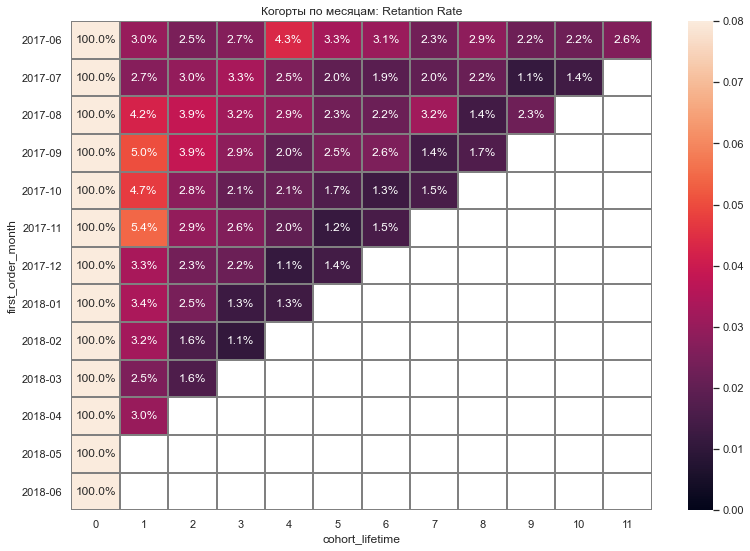

In [33]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Когорты по месяцам: Retantion Rate')

sns.heatmap(retention_pivot, 
            annot=True, 
            fmt='.1%', 
            linewidths=1, 
            linecolor='gray', 
            vmin=0, vmax=0.08)

In [34]:
print('Средний retention rate на второй месяц жизни когорт: {:.1%}'.format(retention_pivot[2].mean()))

Средний retention rate на второй месяц жизни когорт: 2.7%


Самый высокий retention rate у сетнябрьской и ноябрьской когорты в первый месяц. Так же стоит отметить июньскую когорту за 4ый месяц и первый месыц у октябрьской когорты. Если покупатели и возвращаютя, то скорее всего сделают это в течение месяца (возможно дейтсвуют какие-то акции). Те кто с Яндекс Афишей давно в целом возвращаются чаще, однако в целом этот показатель довольно низкий, что свидельствует о том, что мало пользователей возвращается 

#### Метрики электронной коммерции

##### Время с первого визита до покупки

Рассчитаем, сколько времени в среднем проходит с момента первого посещения сайта до совершения покупки

In [35]:
#из таблицы с посещениями достанем время первого визита
first_visits = visits.groupby('uid').agg({'start_ts' : 'min', 'end_ts' : 'min'})

In [36]:
first_visits.reset_index()

,uid,start_ts,end_ts
0,11863502262781,2018-03-01 17:27:00,2018-03-01 17:33:00
1,49537067089222,2018-02-06 15:55:00,2018-02-06 15:57:00
2,297729379853735,2017-06-07 18:47:00,2017-06-07 18:48:00
3,313578113262317,2017-09-18 22:49:00,2017-09-18 23:07:00
4,325320750514679,2017-09-30 14:29:00,2017-09-30 14:38:00
...,...,...,...
228164,18446403737806311543,2017-11-30 03:36:00,2017-11-30 03:39:00
228165,18446424184725333426,2017-12-06 20:32:00,2017-12-06 20:32:00
228166,18446556406699109058,2018-01-01 16:29:00,2018-01-01 16:31:00
228167,18446621818809592527,2017-12-27 13:27:00,2017-12-27 14:08:00


In [37]:
#из таблицы с заказам вытащим первый заказ каждого пользователя
first_order = orders.groupby('uid')['buy_ts'].min()

In [38]:
first_order.reset_index()

,uid,buy_ts
0,313578113262317,2018-01-03 21:51:00
1,1575281904278712,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00
3,2464366381792757,2018-01-28 15:54:00
4,2551852515556206,2017-11-24 10:14:00
...,...,...
36518,18445147675727495770,2017-11-24 09:03:00
36519,18445407535914413204,2017-09-22 23:55:00
36520,18445601152732270159,2018-03-26 22:54:00
36521,18446156210226471712,2018-02-18 19:34:00


In [39]:
#соеденим 2 таблицы
first_visits = first_visits.merge(first_order, on='uid')

In [40]:
first_visits.info() #итоговая таблица стала размером с таблицу с первыми заказами

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 36523 entries, 313578113262317 to 18446167067214817906
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   start_ts  36523 non-null  datetime64[ns]
 1   end_ts    36523 non-null  datetime64[ns]
 2   buy_ts    36523 non-null  datetime64[ns]
dtypes: datetime64[ns](3)
memory usage: 1.1 MB


In [41]:
#вычтем из времени покупки время первого захода на сайт и перевдем его в секунды
first_visits['time_to_buy'] = (first_visits['buy_ts'] - first_visits['start_ts']).dt.seconds
first_visits.head()

,start_ts,end_ts,buy_ts,time_to_buy
uid,,,,
313578113262317,2017-09-18 22:49:00,2017-09-18 23:07:00,2018-01-03 21:51:00,82920
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:17:00,2017-06-03 10:13:00,0
2429014661409475,2017-10-11 17:14:00,2017-10-11 17:27:00,2017-10-11 18:33:00,4740
2464366381792757,2018-01-27 20:10:00,2018-01-27 20:13:00,2018-01-28 15:54:00,71040
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:19,2017-11-24 10:14:00,0


In [42]:
first_visits.head()

,start_ts,end_ts,buy_ts,time_to_buy
uid,,,,
313578113262317,2017-09-18 22:49:00,2017-09-18 23:07:00,2018-01-03 21:51:00,82920
1575281904278712,2017-06-03 10:13:00,2017-06-03 10:17:00,2017-06-03 10:13:00,0
2429014661409475,2017-10-11 17:14:00,2017-10-11 17:27:00,2017-10-11 18:33:00,4740
2464366381792757,2018-01-27 20:10:00,2018-01-27 20:13:00,2018-01-28 15:54:00,71040
2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:19,2017-11-24 10:14:00,0


count    36523.000000
mean     14949.881445
std      25784.567076
min          0.000000
25%        240.000000
50%        960.000000
75%      15120.000000
max      86340.000000
Name: time_to_buy, dtype: float64

Text(0, 0.5, 'Количество пользователей, сделавших заказ')

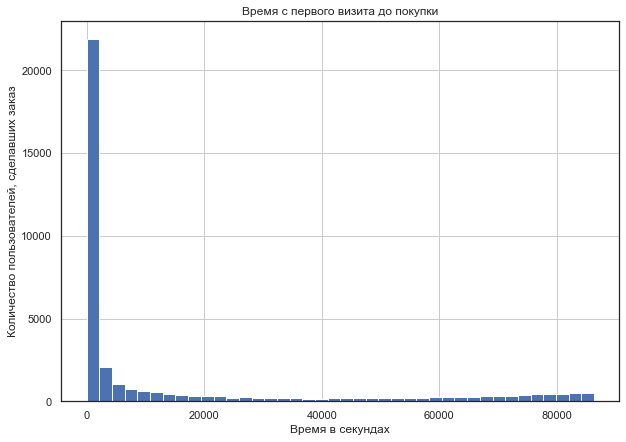

In [43]:
display(first_visits['time_to_buy'].describe())
first_visits['time_to_buy'].hist(bins = 40, figsize=(10, 7))
plt.title('Время с первого визита до покупки')
plt.xlabel('Время в секундах')
plt.ylabel('Количество пользователей, сделавших заказ')

In [44]:
len(first_visits.query('time_to_buy > 79200')['time_to_buy']) / len(first_visits) * 100

4.405443145415218

Из описания столбца видно, что половина всех покупателей совершает покупки в течение 16 мин (960 сек) после первого визита на сайт. Если же покупка не была совершена так быстро, то также возможно (хотя и существенно реже), что пользователь что-то купит в течении 4,2 часов (15120 секунд). Также есть очень небольшая группа пользователей (около 4,5%), которая совершает покупку на слдующий день (то есть спустя более 22 часов). В целом же покупатели принимают решение о покупке очень быстро.

##### Среднее количество покупок на одного покупателя 

In [45]:
#сгруппируем таблицу с заказами по месяцам и колличесву заказов от одного пользователя в этот месяц
orders_per_user = orders.groupby(['order_month','uid']).agg({'buy_ts' : 'count'})
orders_per_user

buy_ts
order_month uid                         
2017-06-01  1575281904278712           2
            16233238570251706          1
            29085576454138824          1
            31782048561502182          1
            50884319066603964          1
...                                  ...
2018-05-01  18417227789295707563       1
            18418973552381796231       1
            18419772037216346332       1
            18428860277441438399       1
2018-06-01  83872787173869366          1

[41019 rows x 1 columns]

In [46]:
orders_per_user = orders_per_user.reset_index()

Text(0, 0.5, 'Количесвто пользователей')

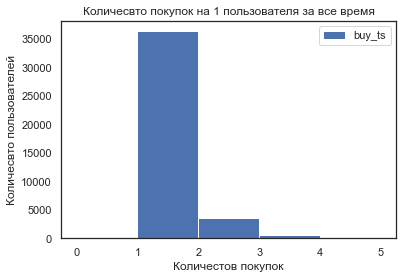

In [47]:
#отобразим на гистограмме количесво покупок на 1 пользователя
orders_per_user.plot(
    kind='hist', 
    y='buy_ts', 
    bins = 5, 
    range=(0, 5))
plt.title('Количесвто покупок на 1 пользователя за все время')
plt.xlabel('Количестов покупок')
plt.ylabel("Количесвто пользователей")

In [48]:
print('Процент людей, которые совершают более 4 покупок в месяц:', 
      (len(orders_per_user.query('buy_ts > 4')) / len(orders_per_user)) * 100)

Процент людей, которые совершают более 4 покупок в месяц: 0.9410273287988493


На гистограмме видно, что подавляющее большинство пользователей совершают лишь 1 покупку в месяц, а те кто совершает больше 4 покупок составляют одного процента


<AxesSubplot:xlabel='order_month'>

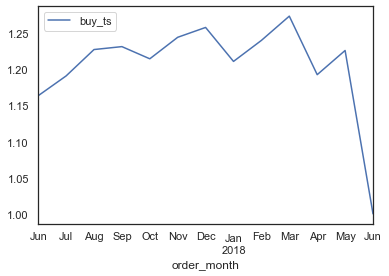

In [49]:
#сделаем сводную таблицу, где за каждый месяц будет среднее количесво заказов от одного пользователя
orders_per_user_pivot = orders_per_user.pivot_table(index ='order_month', values='buy_ts')

orders_per_user_pivot.plot()

In [50]:
print("Среднее количесво покупок на 1 пользователя в месяц за последние полгода:", int(orders_per_user_pivot.tail(6).mean()))

Среднее количесво покупок на 1 пользователя в месяц за последние полгода: 1


Пользователи в среднем совершают одну покупку в месяц, при этом так было примерно на протяжении всего существования сервиса (колебания от 1.15 до 1.25 в пересчете на количесво покупок незначительны). Однако, чтоит заметить, что в июне 2018 пользователи стали совершать в целом меньше покупок (хотя снова это колебания в пределах единицы), возможно данные за этот месяц неполные, либо это объясняется наступлением летних каникул для детей и уходом театров на гастроли. 

##### Средний чек

Сначала рассчитам средний чек по месяцам. Для этого сгруппируем данные по месяцу и посчитаем выручку за каждый месяц и количесвто заказов. 

In [51]:
mean_check = orders.groupby('order_month').agg({'revenue' : 'sum', 'buy_ts' : 'count'})
mean_check['mean_check'] = mean_check['revenue'] / mean_check['buy_ts']

mean_check = mean_check.reset_index()


In [52]:
mean_check

,order_month,revenue,buy_ts,mean_check
0,2017-06-01,9557.49,2354,4.060106
1,2017-07-01,12539.47,2363,5.306589
2,2017-08-01,8758.78,1807,4.847139
3,2017-09-01,18345.51,3387,5.416448
4,2017-10-01,27987.70,5679,4.928280
5,2017-11-01,27069.93,5659,4.783518
6,2017-12-01,36388.60,6218,5.852139
7,2018-01-01,19417.13,4721,4.112927
8,2018-02-01,25560.54,5281,4.840095
9,2018-03-01,28834.59,5326,5.413930


Text(0.5, 0, 'Дата')

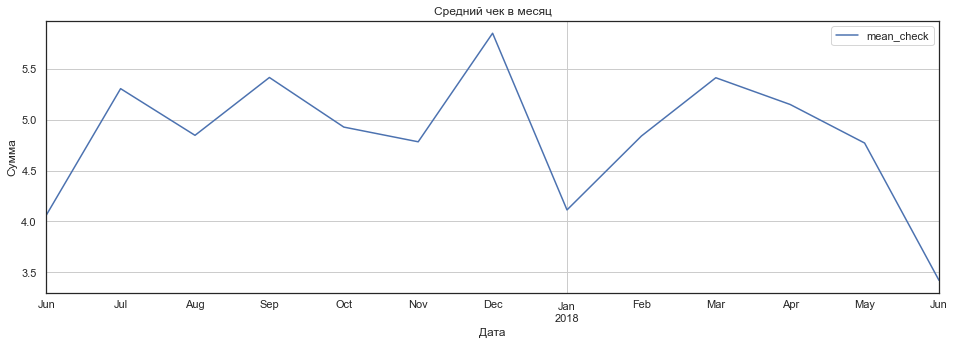

In [53]:

mean_check.plot(x='order_month', y='mean_check', figsize=(16, 5), grid=True)

plt.title('Средний чек в месяц')
plt.ylabel('Сумма')
plt.xlabel('Дата')



In [54]:
print('Средний чек за все время:', mean_check['mean_check'].mean().round(1))

Средний чек за все время: 4.8


Средний чек за весь период сотавляет 4.8 уе, притом, что в разбивке по месяцам самый большой чек был в декабре - что скорее всего объясняется большим колличесвтом мероприятий на новогодние праздники (он составил 5,9 уе). Самый маленький средний 
в июне 2018 (как и самое маленькое количесвто заказов на человека). Возмжожно это также объяняется летними каникулами и гатсролями. Стоит обраратить внимание на спад по среднему чеку в январе, что можно объяснить новогодними праздниками - скорее всег на новый год было много мероприятий и логично, что в январе будет некое насыщение ими, к тому же скорее всего в непосредственно первые недели января вряд ли много людец покупает куда-то билеты

#####  LTV

Рассчитаем "пожизненную стоимость клиента" и узнаем сколько денег он приносит. 

In [55]:
#узнаем месяц первого заказа и приклеиваем его к таблице с заказами
first_orders = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

In [56]:
#снова формируем когорты 
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [57]:
orders.sample(5)

,buy_ts,revenue,uid,buy_date,first_buy_date,first_order_month,order_month
17072,2017-11-11 18:02:00,18.33,17899077652925005086,2017-11-11,2017-11-11,2017-11-01,2017-11-01
19773,2017-11-24 21:39:00,0.55,14965030714373758003,2017-11-24,2017-11-07,2017-11-01,2017-11-01
46362,2018-05-04 21:04:00,4.89,11752879947192160689,2018-05-04,2018-05-04,2018-05-01,2018-05-01
18863,2017-11-22 16:07:00,1.22,10780884444660069286,2017-11-22,2017-11-20,2017-11-01,2017-11-01
21803,2017-12-04 11:31:00,14.67,10029068528085152222,2017-12-04,2017-08-24,2017-08-01,2017-12-01


In [58]:
cohorts_ltv = orders.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
#cohorts_ltv

In [59]:
report = pd.merge(cohort_sizes, cohorts_ltv, on='first_order_month')
report.head()

,first_order_month,n_buyers,order_month,revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [60]:
#знаем, что маржинальность 100%
margin_rate = 1

In [61]:
#найдем валовую прибль и возраст когорты
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [62]:
#Оставим в данных о месяце первого заказа только год и месяц
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y-%m') 

In [63]:
report.head()

,first_order_month,n_buyers,order_month,revenue,gp,age
0,2017-06,2023,2017-06-01,9557.49,9557.49,0
1,2017-06,2023,2017-07-01,981.82,981.82,1
2,2017-06,2023,2017-08-01,885.34,885.34,2
3,2017-06,2023,2017-09-01,1931.30,1931.30,3
4,2017-06,2023,2017-10-01,2068.58,2068.58,4


In [64]:
report['ltv'] = report['gp'] / report['n_buyers']
#report

<AxesSubplot:title={'center':'LTV за весь период'}, xlabel='age', ylabel='first_order_month'>

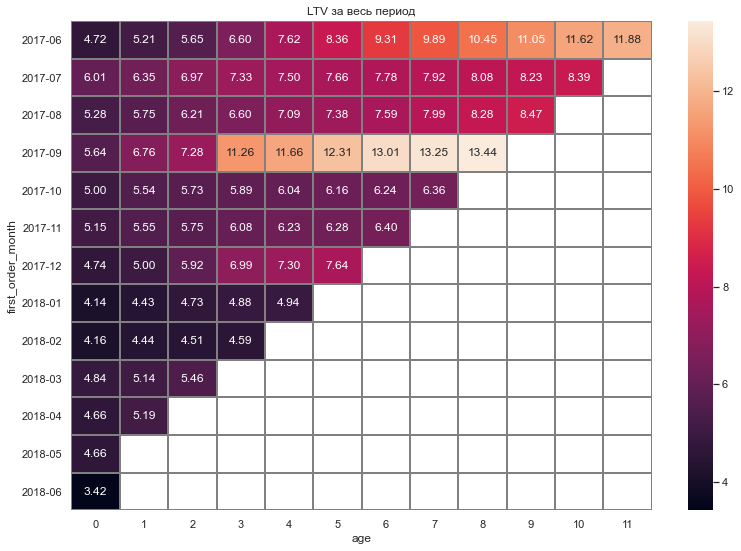

In [65]:
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv').cumsum(axis=1)
output

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV за весь период')
sns.heatmap(output, 
            annot=True, 
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray')

Мы рассчитали LTV за весь период, теперь внимательнее рассмотрим полугодовой период и те когорты, которые прожили 6 месяцев. Отдельно стоит обратить внимание на сентябрьскую и июньскую когорты - они приносят больше всего денег. 

In [66]:
output = output.loc[:'2017-12-01'].loc[:,'0':'5']

In [67]:
output

age,0,1,2,3,4,5
first_order_month,,,,,,
2017-06,4.724414,5.209743,5.647380,6.602051,7.624582,8.360084
2017-07,6.010218,6.345429,6.968960,7.327936,7.504727,7.660775
2017-08,5.276518,5.748511,6.206993,6.598270,7.092321,7.375861
2017-09,5.644529,6.762115,7.283045,11.258838,11.659396,12.306463
2017-10,5.003733,5.539495,5.730889,5.888035,6.039594,6.159956
2017-11,5.154683,5.553916,5.753472,6.078424,6.226437,6.280316
2017-12,4.738191,4.998565,5.923662,6.988937,7.301866,7.639913


In [68]:
output.mean(axis=0)

age
0    5.221755
1    5.736825
2    6.216343
3    7.248927
4    7.635561
5    7.969053
dtype: float64

Получилось, что «пожизненная» ценность клиента из когорт, которые прожили более 6 месяцев, со временем растет. Каждый клиент в среднем приносит от 5 до почти 8 у.е. со всех своих покупок. Чтобы эта метрика была полезнее необходимо обратиться к CAC

####  Маркетинговые метрики

#####  Общая сумму расходов на маркетинг

In [69]:
sources_cost = costs.groupby('source_id').agg({'costs' : 'sum'})
display(sources_cost)
sources_cost.sum()


,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


costs    329131.62
dtype: float64

In [70]:
sources_cost.reset_index()
sources_cost['ratio'] = sources_cost['costs'].apply(lambda x: x / sources_cost.sum())
sources_cost

,costs,ratio
source_id,,
1,20833.27,0.063298
2,42806.04,0.130058
3,141321.63,0.429377
4,61073.60,0.185560
5,51757.10,0.157254
9,5517.49,0.016764
10,5822.49,0.017690


Общая сумма расходов на маркетинг за весь период превышает 320 000 у.е. Самый финансируемый источник - 3. В него вложены в разы больше денег, чем в другие - примерно 40% всех расходов ушло на него. Самые дешевые источники - 9 и 10 - на каждый из них потачено менее 2% денег от общей суммы. 

Посмотрим на затраты на маркетинг в динамике, разбив затраты по источникам и по месяцам 

In [71]:
costs['month'] = costs['dt'].astype('datetime64[M]')
costs_month = costs.groupby(['month','source_id']).agg({'costs' : 'sum'})

In [72]:
costs_month = costs_month.reset_index()
costs_month.head()


,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


Text(0, 0.5, 'Расходы')

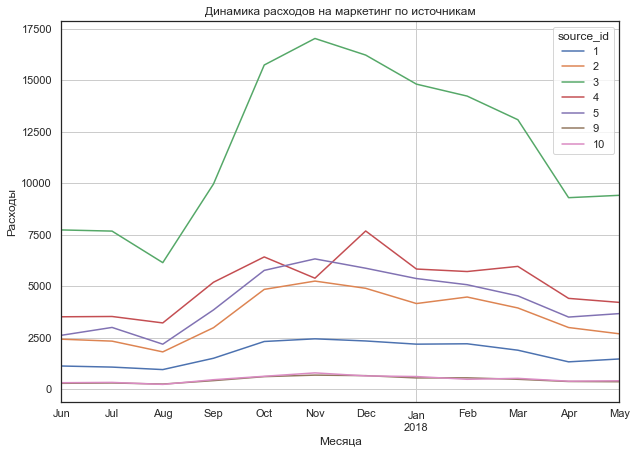

In [73]:
costs_month_pivot = costs.pivot_table(index='month', 
                columns='source_id', 
                values='costs', 
                aggfunc='sum')
#costs_month_pivot

costs_month_pivot.plot(grid=True, 
                       figsize=(10, 7))
plt.title('Динамика расходов на маркетинг по источникам')
plt.xlabel('Месяца')
plt.ylabel('Расходы')


Как и было замечено выше, самый дорогой источник - это 3. Однако у него наблюдается следующая динамика: в агусте был небольшой спад, однако в ноября в этот источник были вложили большие вложения (возможно, с расчетом на то, что в преддверии новогодних праздников это окупится - ксати, почти все остальные источники тоже увеличились по финансированию, видим из тех же соображений). После ноября идет спад, который продолжается вплоть до апреля. У источников 9 и 10 почти нет никакой динамики - на них тратися примерно всегда одинакове количество денег, притом сравнительно с другими источниками небольших.


##### CAC 

Рассчитаем CAC для каждого источника трафика. Для этого нужно определить источник каждого пользователя (так как неисключено, что пользователь попадал на сайт несколько раз из разных источников). Будем считать источником тот, с которого пользователь зашел впервые 

In [74]:
#находим первый источник
first_source = visits.sort_values('start_ts').groupby('uid').agg({'source_id' : 'first'})
first_source = first_source.reset_index()

In [75]:
#приклеиваем его к таблице с заказами
orders_plus = orders.merge(first_source, on = 'uid')


In [76]:
orders_plus

,buy_ts,revenue,uid,buy_date,first_buy_date,first_order_month,order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01,3
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31,2018-05-01,2018-05-01,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31,2018-05-01,2018-05-01,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31,2018-05-01,2018-05-01,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-31,2018-05-01,2018-05-01,3


In [77]:
#считаем сколько в день с какого источника пришло людей
orders_by_day = orders_plus.groupby(['source_id','first_buy_date']).agg({'uid' : 'nunique'}).reset_index()

In [78]:
orders_by_day

,source_id,first_buy_date,uid
0,1,2017-06-01,14
1,1,2017-06-02,7
2,1,2017-06-03,7
3,1,2017-06-04,3
4,1,2017-06-05,18
...,...,...,...
2430,10,2018-05-27,2
2431,10,2018-05-28,10
2432,10,2018-05-29,7
2433,10,2018-05-30,5


In [79]:
#считаем сколько денег в каждый день потрачено на каждый источник
costs_by_day = costs.groupby(['source_id','dt']).agg({'costs' : 'sum'}).reset_index()
costs_by_day.columns = ['source_id','first_buy_date', 'costs']
costs_by_day

,source_id,first_buy_date,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
...,...,...,...
2537,10,2018-05-27,9.92
2538,10,2018-05-28,21.26
2539,10,2018-05-29,11.32
2540,10,2018-05-30,33.15


In [80]:
#соединяем 2 таблицы
cac_by_day = orders_by_day.merge(costs_by_day, on=['source_id', 'first_buy_date'])

In [81]:
cac_by_day

,source_id,first_buy_date,uid,costs
0,1,2017-06-01,14,75.20
1,1,2017-06-02,7,62.25
2,1,2017-06-03,7,36.53
3,1,2017-06-04,3,55.00
4,1,2017-06-05,18,57.08
...,...,...,...,...
2428,10,2018-05-27,2,9.92
2429,10,2018-05-28,10,21.26
2430,10,2018-05-29,7,11.32
2431,10,2018-05-30,5,33.15


In [82]:
#считаем сас
cac_by_day['cac'] = cac_by_day['costs'] / cac_by_day['uid']
#усредняем по источникам
cac_source = cac_by_day.groupby('source_id').agg({'cac' : 'mean'}).reset_index()
cac_source

,source_id,cac
0,1,9.489732
1,2,16.287024
2,3,15.580474
3,4,7.271743
4,5,8.336731
5,9,6.842532
6,10,6.555415


In [83]:
cac_source['cac'].mean()

10.05194996507244

Средняя стоимость привлечения клиентов за все время проекта по всем источникам составляет около 10 уе., что выше LTV (хотя мы не расчитывали ltv за весь проект, но за послений рассичтываемы месяц это было 7,9). Это говорит о том, что на привлечение одного клиента тратится больше денег, чем один клиен приносит прибыли. Самые дорогие источники - источник 2 (один покупатель из этого источника стоит в среднем 16,3 уе) и источник 3 (соответсвенно 15,6 уе). Самые дешевые источники - 9 и 10 

Также посмотрим на САС в динамике 

In [84]:
#вытаскиваем месяц из даты
cac_by_day['month'] = cac_by_day['first_buy_date'].astype('datetime64[M]')

In [85]:
#делаем сводную таблицу по месяцам и источникам
report_cac = cac_by_day.pivot_table(index='month', columns='source_id', values='cac')

In [86]:
report_cac

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,11.681283,12.883568,16.716919,10.792094,9.209676,5.253654,4.590158
2017-07-01,9.491485,18.000253,18.593952,8.054482,7.938157,5.582433,6.151880
2017-08-01,12.118898,18.886449,19.795068,11.554926,6.879620,4.900254,5.813398
2017-09-01,8.155731,17.672249,13.084043,9.533800,6.864844,6.049126,8.306581
2017-10-01,8.202083,14.193003,14.613088,6.233562,6.305969,5.923235,6.362921
2017-11-01,8.908503,17.437690,16.091445,5.013132,9.368019,9.400503,10.801337
2017-12-01,8.570439,13.871086,12.948321,5.656507,8.399174,7.899420,7.803197
2018-01-01,11.719181,15.850151,15.134989,5.901092,9.371755,9.792713,9.851557
2018-02-01,10.752216,18.209325,13.894612,5.428068,7.725369,8.181382,4.489624


In [87]:
report_cac.mean() #проверяем, что мы ничего не потеряли - средний сас сходится 

source_id
1      9.504800
2     16.314058
3     15.566601
4      7.259773
5      8.345224
9      6.774400
10     6.497916
dtype: float64

Text(0, 0.5, 'Стоимость, у.е.')

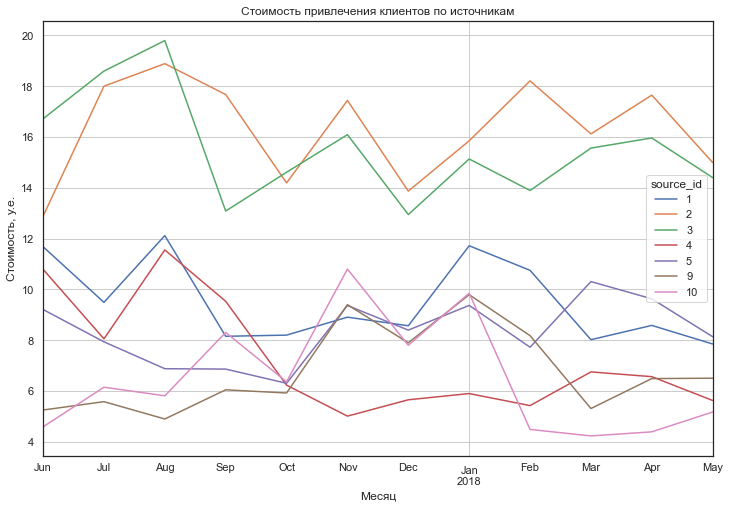

In [88]:
report_cac.plot(grid=True, 
              figsize=(12, 8))
plt.title('Стоимость привлечения клиентов по источникам')
plt.xlabel('Месяц')
plt.ylabel('Стоимость, у.е.')

Видно, что по самым дорогим источникам (2 и 3) наблюдается схожая динамика: в августе стоимость привлечения клиентов была наибольшей, а в сентябре-октябре - наименьшей. Возможно такая скачкообразность объясняется тем, что это некий цикличные процесс: на привлечение клиетов тратятся средства (например, в августе), дальше они приносят неких доход, осваиваются на сервисе, а новые привлекаются менее активно. Затем в ноябре (а потом в феврале) снова тратится больше денег на привлечение новых клиентов. 

##### ROMI по когортам в разрезе источников

Посчитаем LTV по источникам 

In [89]:
#воспользуемся таблицей, где у заказов указан источник привлечения 
orders_plus

,buy_ts,revenue,uid,buy_date,first_buy_date,first_order_month,order_month,source_id
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,2017-06-01,2017-06-01,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,2017-06-01,2017-06-01,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,2017-06-01,2017-06-01,3
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-31,2018-05-31,2018-05-01,2018-05-01,4
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-31,2018-05-31,2018-05-01,2018-05-01,10
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-31,2018-05-31,2018-05-01,2018-05-01,3
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-31,2018-05-31,2018-05-01,2018-05-01,3


In [90]:
#формируем новые когорты по месяцу и по источнику
cohort_source_sizes = orders_plus.groupby(['first_order_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_source_sizes.head(10)

#в первой строке: в июньской когорте, пришедшей из источника 1 190 человек

,first_order_month,source_id,uid
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
5,2017-06-01,9,68
6,2017-06-01,10,95
7,2017-07-01,1,160
8,2017-07-01,2,208
9,2017-07-01,3,512


In [91]:
#переименуем столбцы для удобства
cohort_source_sizes.columns = ['first_order_month', 'source_id','n_buyers']
cohort_source_sizes


,first_order_month,source_id,n_buyers
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384
...,...,...,...
81,2018-05-01,4,804
82,2018-05-01,5,497
83,2018-05-01,9,60
84,2018-05-01,10,130


In [92]:
#формируе когорты по источникам
source_cohorts = orders_plus.groupby(['first_order_month','order_month', 'source_id']).agg({'revenue': 'sum'}).reset_index()
source_cohorts.head(10)

#в певрой строке: те кто, пришли из первого источника в июньской когорте принесли 1378 уе за июнь

,first_order_month,order_month,source_id,revenue
0,2017-06-01,2017-06-01,1,1378.70
1,2017-06-01,2017-06-01,2,1043.68
2,2017-06-01,2017-06-01,3,2804.34
3,2017-06-01,2017-06-01,4,1959.84
4,2017-06-01,2017-06-01,5,1898.89
5,2017-06-01,2017-06-01,9,242.69
6,2017-06-01,2017-06-01,10,229.35
7,2017-06-01,2017-07-01,1,414.98
8,2017-06-01,2017-07-01,2,115.54
9,2017-06-01,2017-07-01,3,71.97


In [93]:
#соединяем 2 таблицы
report_source = pd.merge(cohort_source_sizes, source_cohorts, on=['first_order_month', 'source_id'])
report_source.head(10)

#в первой строке: те кто, пришли из первого источника в июньской когорте принесли 1378 уе за июнь и их было 190 человек
#во второй: они же, но за июль

,first_order_month,source_id,n_buyers,order_month,revenue
0,2017-06-01,1,190,2017-06-01,1378.70
1,2017-06-01,1,190,2017-07-01,414.98
2,2017-06-01,1,190,2017-08-01,419.43
3,2017-06-01,1,190,2017-09-01,714.24
4,2017-06-01,1,190,2017-10-01,811.20
5,2017-06-01,1,190,2017-11-01,389.34
6,2017-06-01,1,190,2017-12-01,490.48
7,2017-06-01,1,190,2018-01-01,479.23
8,2017-06-01,1,190,2018-02-01,432.15
9,2017-06-01,1,190,2018-03-01,316.30


In [94]:
#расчитаем необходимые компаненты для ltv
#тк это относительный показатель будем смотреть его по «возрастным» когортам, где возраст (age) когорты, (а не месяц, как у САС)
report_source['gp'] = report_source['revenue'] * margin_rate
report_source['age'] = (report_source['order_month'] - report_source['first_order_month']) / np.timedelta64(1, 'M')
report_source['age'] = report_source['age'].round().astype('int')

In [95]:
report_source['ltv'] = report_source['gp'] / report_source['n_buyers']

In [96]:
#сводная по 2м полям 

output_s = report_source.pivot_table(
        index=['first_order_month', 'source_id'], 
        columns='age', 
        values='ltv',
        aggfunc = 'sum').cumsum(axis=1)
output_s.head(10)

# в первой строке: те люди июньско когорты, которые пришли из первого источника в конце первого месяца принесли 7,3,
# а люди этой жекогорты, которые пришли из источника 2 в конце первого месяца принесли 4,4

age                                0         1          2          3   \
first_order_month source_id                                             
2017-06-01        1          7.256316  9.440421  11.647947  15.407105   
                  2          4.441191  4.932851   5.204766   7.129660   
                  3          4.395517  4.508323   4.694734   5.005940   
                  4          4.745375  4.785714   4.956586   5.416005   
                  5          4.945026  5.847969   6.297266   7.170000   
                  9          3.568971  3.640735   4.228676   4.835882   
                  10         2.414211  2.530632        NaN        NaN   
2017-07-01        1          7.291875  8.387562  13.742187  15.249187   
                  2          8.429663  9.195240   9.254567   9.576346   
                  3          6.105117  6.367891   6.491680   6.885664   

age                                 4          5          6          7   \
first_order_month source_id                                               
2017-06-01        1          19.676579  21.725737  24.307211  26.829474   
                  2           8.796468   9.715447  11.317660  12.799787   
                  3           5.191646   5.384875   5.512790   5.542398   
                  4           6.564431   8.053317   9.482639   9.715738   
                  5           7.833307   8.131042   9.036380   9.623464   
                  9           5.103382   5.546029   6.077941   6.201912   
                  10               NaN        NaN        NaN        NaN   
2017-07-01        1          16.127500  17.027375  17.474250  18.120375   
                  2          10.008510  10.194760  10.493606  10.630625   
                  3           6.925645   6.996621   7.033125   7.165332   

age                                 8          9          10         11  
first_order_month source_id                                              
2017-06-01        1          29.103947  30.768684  31.973526  33.644158  
                  2          14.135106  14.868809  16.227404  16.660681  
                  3           5.592445   5.645486   5.673652   5.705831  
                  4           9.932300  10.734939  12.003898  12.088789  
                  5          10.181849  11.127422  11.283464  11.400104  
                  9           6.739559   6.862500   6.943382        NaN  
                  10          2.539579        NaN        NaN        NaN  
2017-07-01        1          18.977438  19.962813  20.890750        NaN  
                  2          10.741731  10.970769  11.334471        NaN  
                  3           7.249434   7.290234   7.345781        NaN

In [97]:
#перегруппируем по источнику и усредним (!) значение
ltv_source = output_s.reset_index().groupby(['source_id']).mean().reset_index()
ltv_source.groupby('source_id').mean()

# в первой строке: все люди, которые пришли из первого источника в среднем (!) в конце первого месяца принесли 6.3

age,0,1,2,3,4,5,6,7,8,9,10,11
source_id,,,,,,,,,,,,
1,6.314485,7.461027,8.872668,9.631347,10.885888,12.011587,13.764442,15.773543,19.099941,23.137372,26.432138,33.644158
2,6.501886,8.124888,9.974403,12.088853,13.802794,15.491555,12.831257,14.057100,14.952440,11.384710,13.780938,16.660681
3,4.605593,4.993997,5.082104,5.263492,5.506471,5.730149,5.963324,6.238408,6.451284,6.357396,6.509717,5.705831
4,4.571089,4.856674,4.944971,5.174440,5.512052,6.032379,6.806730,6.976438,7.547291,7.822755,9.141814,12.088789
5,4.834917,5.203086,5.584781,7.680864,8.445984,9.345449,10.325525,11.603362,13.222684,9.318310,9.031649,11.400104
7,1.220000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.008411,4.349240,4.582181,5.103295,5.324953,5.815051,6.260591,6.838968,7.282024,6.585210,6.992653,NaN
10,3.267817,3.393989,3.504842,3.454445,3.448987,3.930334,3.940346,3.674350,2.941408,5.654324,NaN,NaN


Добавим к таблице расходы, чтобы можно было посчитать ROMI

In [98]:
#чтобы ничего не потерять возьмем пока неусредненные сас 
cac_by_day

,source_id,first_buy_date,uid,costs,cac,month
0,1,2017-06-01,14,75.20,5.371429,2017-06-01
1,1,2017-06-02,7,62.25,8.892857,2017-06-01
2,1,2017-06-03,7,36.53,5.218571,2017-06-01
3,1,2017-06-04,3,55.00,18.333333,2017-06-01
4,1,2017-06-05,18,57.08,3.171111,2017-06-01
...,...,...,...,...,...,...
2428,10,2018-05-27,2,9.92,4.960000,2018-05-01
2429,10,2018-05-28,10,21.26,2.126000,2018-05-01
2430,10,2018-05-29,7,11.32,1.617143,2018-05-01
2431,10,2018-05-30,5,33.15,6.630000,2018-05-01


In [99]:
#сгруппируем по месяцу и источнику и усредним
cac_group = cac_by_day.groupby(['source_id', 'month'])['cac'].mean()
cac_group2 = cac_group.reset_index()
cac_group2

#в первой строке: средний сас за июнь по первому источнику

,source_id,month,cac
0,1,2017-06-01,11.681283
1,1,2017-07-01,9.491485
2,1,2017-08-01,12.118898
3,1,2017-09-01,8.155731
4,1,2017-10-01,8.202083
...,...,...,...
79,10,2018-01-01,9.851557
80,10,2018-02-01,4.489624
81,10,2018-03-01,4.233605
82,10,2018-04-01,4.394415


In [100]:
#переименуем столбцы для удобства
cac_group2.columns = ['source_id', 'first_order_month', 'cac']

In [101]:
#соединяем с ltv и считаем romi
report_source_trial = report_source.merge(cac_group2, on=['source_id','first_order_month'])
report_source_trial['romi'] = report_source_trial['ltv'] / report_source_trial['cac']
report_source_trial.head(10)

,first_order_month,source_id,n_buyers,order_month,revenue,gp,age,ltv,cac,romi
0,2017-06-01,1,190,2017-06-01,1378.70,1378.70,0,7.256316,11.681283,0.621192
1,2017-06-01,1,190,2017-07-01,414.98,414.98,1,2.184105,11.681283,0.186975
2,2017-06-01,1,190,2017-08-01,419.43,419.43,2,2.207526,11.681283,0.188980
3,2017-06-01,1,190,2017-09-01,714.24,714.24,3,3.759158,11.681283,0.321810
4,2017-06-01,1,190,2017-10-01,811.20,811.20,4,4.269474,11.681283,0.365497
5,2017-06-01,1,190,2017-11-01,389.34,389.34,5,2.049158,11.681283,0.175422
6,2017-06-01,1,190,2017-12-01,490.48,490.48,6,2.581474,11.681283,0.220992
7,2017-06-01,1,190,2018-01-01,479.23,479.23,7,2.522263,11.681283,0.215923
8,2017-06-01,1,190,2018-02-01,432.15,432.15,8,2.274474,11.681283,0.194711
9,2017-06-01,1,190,2018-03-01,316.30,316.30,9,1.664737,11.681283,0.142513


Сначала выведем сводную таблицу по всем данным, а потом посмотрим только когорты прожившие не менее 6 месяцев

In [102]:
output_trial = report_source_trial.pivot_table(
        index= ['first_order_month', 'source_id'],
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2) 

output_trial.head(10)

age                            0     1     2     3     4     5     6     7   \
first_order_month source_id                                                   
2017-06-01        1          0.62  0.81  1.00  1.32  1.68  1.86  2.08  2.30   
                  2          0.34  0.38  0.40  0.55  0.68  0.75  0.88  0.99   
                  3          0.26  0.27  0.28  0.30  0.31  0.32  0.33  0.33   
                  4          0.44  0.44  0.46  0.50  0.61  0.75  0.88  0.90   
                  5          0.54  0.63  0.68  0.78  0.85  0.88  0.98  1.04   
                  9          0.68  0.69  0.80  0.92  0.97  1.06  1.16  1.18   
                  10         0.53  0.55   NaN   NaN   NaN   NaN   NaN   NaN   
2017-07-01        1          0.77  0.88  1.45  1.61  1.70  1.79  1.84  1.91   
                  2          0.47  0.51  0.51  0.53  0.56  0.57  0.58  0.59   
                  3          0.33  0.34  0.35  0.37  0.37  0.38  0.38  0.39   

age                            8     9     10    11  
first_order_month source_id                          
2017-06-01        1          2.49  2.63  2.74  2.88  
                  2          1.10  1.15  1.26  1.29  
                  3          0.33  0.34  0.34  0.34  
                  4          0.92  0.99  1.11  1.12  
                  5          1.11  1.21  1.23  1.24  
                  9          1.28  1.31  1.32   NaN  
                  10         0.55   NaN   NaN   NaN  
2017-07-01        1          2.00  2.10  2.20   NaN  
                  2          0.60  0.61  0.63   NaN  
                  3          0.39  0.39  0.40   NaN

<AxesSubplot:title={'center':'ROMI по когортам в разрезе источников '}, xlabel='age', ylabel='source_id'>

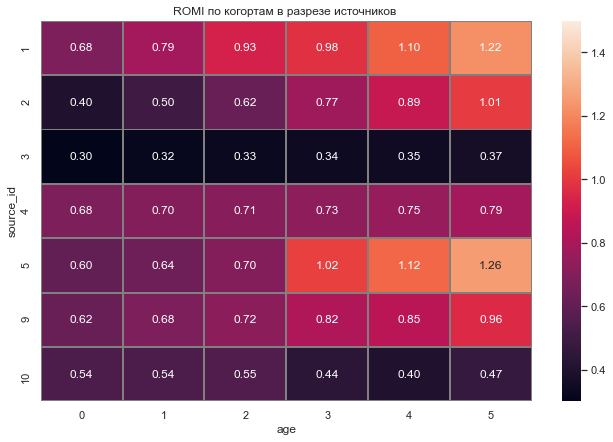

In [103]:
#перегруппируем по источнику и посчитаем среднее
trial = output_trial.reset_index().groupby(['source_id']).mean().reset_index()
output_again = trial.groupby('source_id').mean().round(2).T


#отрежем когорты, которые живут менее 6 месяцев
final_output = output_again.head(6).T


sns.set(style='white')
plt.figure(figsize=(11, 7))
plt.title('ROMI по когортам в разрезе источников ')
sns.heatmap(final_output, 
            annot=True, 
            fmt='.2f', 
            linewidths=1, 
            linecolor='gray',
            vmax=1.5)

In [104]:
#считаем среднюю когорту 
output_again.head(6).T.mean()

age
0    0.545714
1    0.595714
2    0.651429
3    0.728571
4    0.780000
5    0.868571
dtype: float64

Согласно нашим расчетам к концу 6го месяца проект в целом не окупился - затраты на привлечение клиента привышают доход, который приносят клиенты. Однако, некотрые источнки все же окупились: так самый дорогой источник 2 окупился к концу шестого месяца, источник 1 - к концу пятого и источник 5 быстрее всего к концу четвертого. Также стоит обрать внимание на источник 9 - стоимость привлечения клиентов у него одна из самых низких, и очень вероятно, что к концу седьмого месяца он тоже окупится  

### Выводы и рекомендации

1. Рассчет экономики одного покупателя, с использованием маркетинговых метрик LTV и CAC показал нерадостную ситуацию: привлечение одного клинта стоит больше, чем этот клиент приносит. Это отражается и на ROMI - за полгода проект в целом не окупается. Однако если смотреть на ситуацию в разрезе источников, откуда приходят покупатели, то перераспределение бюджета мжет изменить ситуацию. Стоит отказаться от источника 3, так как он один из двух самых дорогих, приэтом за полгода он не окупился. Более внимательнос стоит отнестись к источникам 1 и 5 - привлечение клиентов по ним относительно недорогое и приэтом они окупаются меньше, чем за полгода. Также потенциально интересный источник 9.

2. Рассчет продуктовых метрик показал, что активность пользователей довольно высокая и стабильная (более 900 пользователей в день в среднем). Они заходят на сайт в среднем раз в день и довольно быстро принимают решение о покупки билета (в течение минуты). Можно предположить, что пользователи изучают репертуар и афиши где-то в другом месте, а Яндекс.Афишей пользутся лишь для покупки билета. Однако у пользователей очень низкий коэффециент удержания - они редко возвращаются за повторной покупкой. Хотя если пользователи и возвращаются за покупкой они делают это в течение месяца. Возможно, стоит попытаться привлечь старых пользователей каими-то дополнительными боусами или акциями  

3. Метрики электронной коммерции показали, что в среднем покупатели довольно быстро совершают заказ, если отсчитывать время от момента первого визита - половине из них хватает 16 мин. Однако среднее количество покупок на 1 пользователя довольно мало - всего лишь 1. Возожно стоит как-то простимулировать покупателей совершать больше покупок и в этом свете внимательнее рассмотреть пользователей, котрые с сервисом давно - они покупают чаще. Не исключено, что у них есть какие-то дополнительные условия или возможности, которые можно предоставить и другим пользователям. 

4. Когортный анализ показал, что самые перспективные клиенты приходят в июне и сентябре. Про сентярь можно предположить, что люди, которые впервые покупают билеты куда-то в начале учебного года (и театрального сезона) в целом остатся довольны свои опытом после летних каникул и готовы покупать еще. 